# simulated pump probe for testing ridge, constrained, or more advanced regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd

## making simulated data

In [2]:
def y(t,a,w,phi,tau):
    return 50+np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


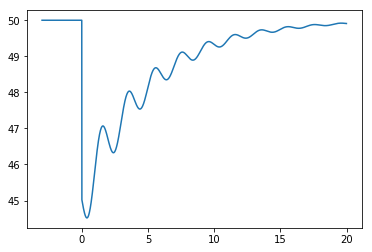

In [3]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [234]:
t_sim     =  np.random.rand(4*len(t))*23-3
e_sim     =  np.random.normal(916,3,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5) #+np.random.normal(0,1,len(t_sim))
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_sim)**2/4**2)+np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim * (e_sim-895) +np.random.normal(0,1,len(t_sim))**2

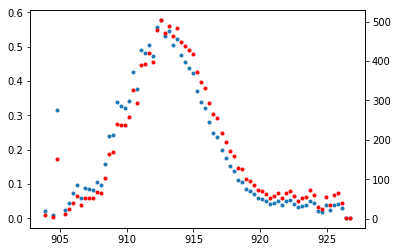

In [235]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')

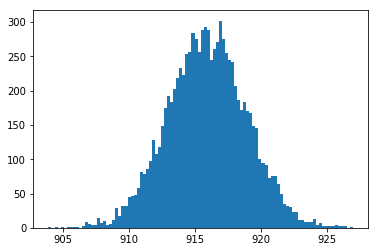

In [236]:
dummy_hist = plt.hist(e_sim,bins=100)

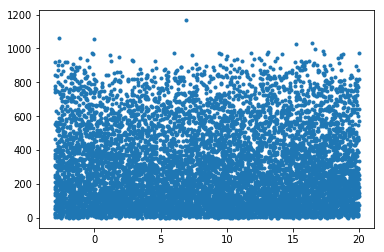

In [237]:
plt.plot(t_sim,I_sim,'.')
plt.show()

## standard bin by bin regression

In [238]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    my_pump_probe.append(beta)

In [239]:
my_pump_probe = np.array(my_pump_probe)

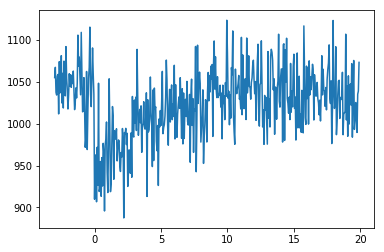

In [240]:
plt.plot(t_bins[:-1],my_pump_probe[:,1])

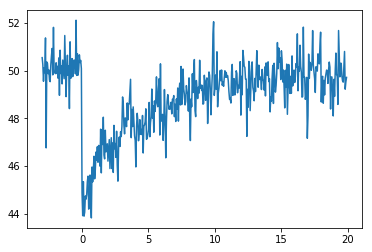

In [241]:
plt.plot(t_bins[:-1],my_pump_probe[:,3])

## ridge regression

In [242]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
big_Y = np.zeros([I_sim.shape[0],t_bins.shape[0]])

my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = (np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()
    Y = I_sim[my_mask]
    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X
    big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol] = Y
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    
    my_ycol = my_ycol + 1
    my_yrow = my_yrow + Y.shape[0]

    
    #beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    #my_pump_probe.append(beta)

In [243]:
big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol:my_ycol +1].shape

(16, 1)

In [244]:
big_X.shape

(9200, 1840)

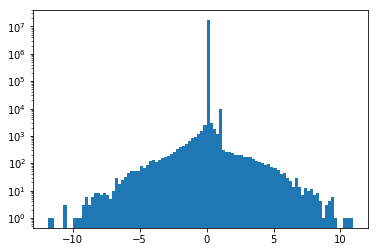

In [245]:
my_hist = plt.hist(big_X.flatten(),bins=100,log=True)

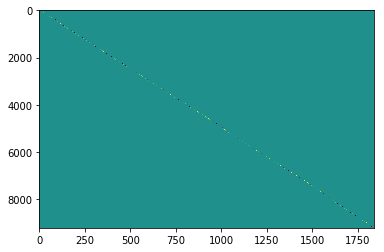

In [246]:
plt.imshow(big_X,aspect='auto',clim=(-2,2))

In [247]:
pseudo_inv = np.linalg.pinv(big_X)

In [248]:
beta = np.dot(pseudo_inv,y_sim)

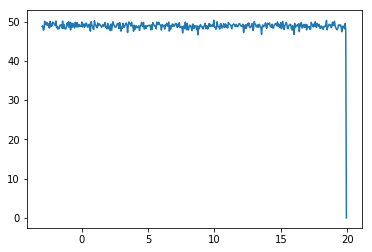

In [249]:
plt.plot(t_bins,beta[0::4])

In [250]:
t_bins.shape

(460,)

## diagonal beta

In [251]:
beta = np.dot(pseudo_inv,big_Y)

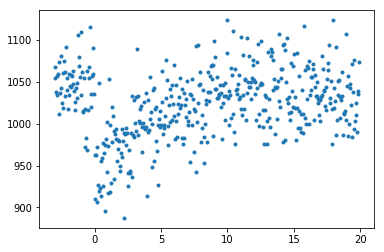

In [252]:
plt.plot(t_bins[:-1],np.diag(beta[1::4][:-1]),'.')

(40, 55)

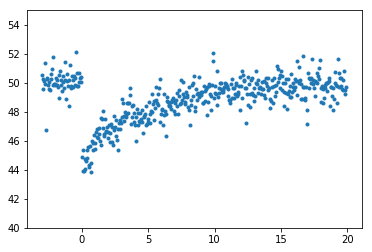

In [253]:
plt.plot(t_bins,np.diag(beta[3::4]),'.')
plt.ylim(40,55)

In [254]:
#now need to implement the tikhonov matrix to constrain standard dev of beta parameters that aren't pump probe
#related and use cross validation to tune them.